## This is a project to track and analyse performance in the league of legends arena mode.

# Importer from riot api
## API Webpage = https://developer.riotgames.com/
You need a new api key every 24 hours

# Inputs

###  Fill in every game:

In [220]:
TeammateChamp = ''  # Manually inputted teammate champ name
PremadeYes = False  # Manually inputted premade status

### Fill in once


In [222]:
API_KEY = '' #Extract from the webpage above
SUMMONER_NAME = ''#Your in-game name, found via in-game profile. You should know this
REGION = '' #redundant
GLOBAL_REGION = '' #Choose from "europe","america","asia", and "esports" (unlikely)
gameName = "" # same as SUMMONER_NAME probably
tagLine = "" #your tag after your name in league eg "inter"

# Megafunction (start to finish, no analysis)

In [223]:
import requests
import json
import csv


# List of prismatic items
prismatic_items = [
    "Eleisa's Miracle", "Gambler's Blade", "Night Harvester", "Cruelty", "Hemomancer's Helm",
    "Cloak of Starry Night", "Hamstringer", "Shield of Molten Stone", "Runecarver", "Flesheater",
    "Sanguine Gift", "Demonic Embrace", "Dragonheart", "Reality Fracture", "Duskblade of Draktharr",
    "Talisman of Ascension", "Turbo Chemtank", "Darksteel Talons", "Mirage Blade", "Sword of the Divine",
    "Empyrean Promise", "Divine Sunderer", "Decaitator", "Force of Entropy", "Detonation Orb",
    "Crown of the Shattered Queen", "Innervating Locket", "Prowler's Claw", "Radiant Virtue",
    "Moonflar Spellblade", "Demon King's Crown", "Overlord's Broodmail", "Gargoyle Stoneplate",
    "Everfrost", "Fulmination", "Galeforce"
]


# Load item data from JSON file
with open('item.json', 'r') as f:
    item_data = json.load(f)

# Load augments data from JSON file and create a dictionary for quick lookup
with open('augments.json', 'r') as f:
    augments_data = json.load(f)
    augments_dict = {augment['id']: augment['nameTRA'] for augment in augments_data}

# Function to get augment name based on ID using the dictionary
def get_augment_name(augment_id):
    augment_name = augments_dict.get(augment_id, '')
    return augment_name


# 1. Get Summoner ID
summoner_url = f'https://{GLOBAL_REGION}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}'
response = requests.get(summoner_url, headers={"X-Riot-Token": API_KEY})
summoner_data = response.json()
puuid = summoner_data['puuid']

# Step 2: Get Match History (Assuming last match)
match_history_url = f'https://{GLOBAL_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=1'
response = requests.get(match_history_url, headers={"X-Riot-Token": API_KEY})
match_ids = response.json()
last_match_id = match_ids[0]

# Step 3: Get Match Details
match_details_url = f'https://{GLOBAL_REGION}.api.riotgames.com/lol/match/v5/matches/{last_match_id}'
response = requests.get(match_details_url, headers={"X-Riot-Token": API_KEY})
match_details = response.json()

# Step 4: Extract your specific data from the match details
my_data = None
for participant in match_details['info']['participants']:
    if participant['puuid'] == puuid:
        my_data = participant
        break

# Step 5: Create a dictionary to map item IDs to item names
item_dict = {item_id: details['name'] for item_id, details in item_data['data'].items()}

# Step 6: Extract specific data and prepare for CSV
if my_data:
    extracted_data = {
        'Champ': my_data.get('championName', ''),
        'Game': '',  # Placeholder for the game number
        'Prism': '',  # Placeholder for Prism augment, adjust as needed
        'Aug 1': get_augment_name(my_data.get('playerAugment1', 0)),
        'Aug 2': get_augment_name(my_data.get('playerAugment2', 0)),
        'Aug 3': get_augment_name(my_data.get('playerAugment3', 0)),
        'Aug 4': get_augment_name(my_data.get('playerAugment4', 0)),
        'Placement': my_data.get('placement', 0),
        'Teammate': TeammateChamp,
        'IsPremade': 'Yes' if PremadeYes else 'No',
        'Kills': my_data.get('kills', 0),
        'Deaths': my_data.get('deaths', 0),
        'Assists': my_data.get('assists', 0),  # Add assists data here
        'Damage': my_data.get('totalDamageDealt', 0),   
        'Item 0': item_dict.get(str(my_data.get('item0', 0)), ''),
        'Item 1': item_dict.get(str(my_data.get('item1', 0)), ''),
        'Item 2': item_dict.get(str(my_data.get('item2', 0)), ''),
        'Item 3': item_dict.get(str(my_data.get('item3', 0)), ''),
        'Item 4': item_dict.get(str(my_data.get('item4', 0)), ''),
        'Item 5': item_dict.get(str(my_data.get('item5', 0)), ''),
        'Item 6': item_dict.get(str(my_data.get('item6', 0)), '')
    }
    
    # Check for prismatic items equipped
    for i in range(7):
        item_name = item_dict.get(str(my_data.get(f'item{i}', 0)), '')
        if item_name in prismatic_items:
            extracted_data['Prism'] = item_name
            break
    
    # Check for duplicates in the CSV file and set the game number
    last_game_number = 0
    duplicate_row = False
    try:
        with open('ArenaTracker.csv', 'r', newline='') as file:
            count = 0
            reader = csv.DictReader(file)
            for row in reader:
                # Check for duplicate excluding 'Champ' and 'Game' columns
                if row['Champ'] == extracted_data['Champ']:
                    count+=1
            last_game_number = count+1
    except FileNotFoundError:
        # If the file does not exist, start the game number at 1
        last_game_number = 1


    # Set the game number based on the condition
    extracted_data['Game'] = str(last_game_number if last_game_number > 0 else 1)


    # Append to CSV file
    with open('ArenaTracker.csv', 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=extracted_data.keys())
        writer.writerow(extracted_data)
        print("Data appended successfully.")
        print("Data Added is: ",extracted_data)
else:
    print("Your data was not found in the match details.")


from csv import reader

### data set ###
opened_file = open('ArenaTracker.csv')
read_file = reader(opened_file)
arena = list(read_file)
arena_header = arena[0]
arena = arena[1:]

#to make a list of augments
def collater(column, lib):
    for item in column:
        if item not in lib:
            lib.append(item)
    return lib

def extract_column(matrix, col_index):
    column = []
    for row in matrix:
        if len(row) > col_index:
            column.append(row[col_index])
    return column

#### Lists by Column

champset = extract_column(arena, 0)
gameset = extract_column(arena, 1)
prismset = extract_column(arena, 2)
firstaug = extract_column(arena, 3)
secondaug = extract_column(arena, 4)
thirdaug = extract_column(arena, 5)
fourthaug = extract_column(arena, 6)
placeset = extract_column(arena, 7)
teamset = extract_column(arena, 8)
killset = extract_column(arena, 10)
deathset = extract_column(arena, 11)
assistset = extract_column(arena, 12)
damageset = extract_column(arena, 13)
item1set = extract_column(arena, 14)
item2set = extract_column(arena, 15)
item3set = extract_column(arena, 16)
item4set = extract_column(arena, 17)
item5set = extract_column(arena, 18)
item6set = extract_column(arena, 19)

augset1 = []
augset1.append(firstaug)
augset1.append(secondaug)
augset1.append(thirdaug)
augset1.append(fourthaug)

augset = []
for row in augset1:
    for item in row:
        augset.append(item)
        
itemset1 = []
itemset1.append(item1set)
itemset1.append(item2set)
itemset1.append(item3set)
itemset1.append(item4set)
itemset1.append(item5set)
itemset1.append(item6set)

itemset = []
for row in itemset1:
    for item in row:
        itemset.append(item)
    
### Making inventories
champs = []
games = []
augments = []
items = []
places = []
teammates = []
prismatics = []



champs = collater(champset,champs)
games = collater(gameset, games)
augments = collater (augset,augments)
items = collater(itemset,items)
places = collater(placeset,places)
teammates = collater(teamset, teammates)
prismatics = collater(prismset, prismatics)


### Finished champs

wins_left = 60
for row in arena:
    placement_game = row[7]
    champ_name = row[0]
    game_number = row[1]
    if placement_game == "1":
        print("\n", champ_name,"is finished. It took",game_number,"games.")
        wins_left = wins_left-1
avg_per_win = len(arena)/(60-wins_left)
if wins_left == 60:
        print("No champs are finished.")
print("\n Wins left before title:",wins_left)
print("Total games played:", len(arena))
print("Average games per win is",avg_per_win)
print("At this rate it will take",(wins_left*avg_per_win),"more games to finish the challenge")

Data appended successfully.
Data Added is:  {'Champ': 'AurelionSol', 'Game': '2', 'Prism': 'Detonation Orb', 'Aug 1': "It's Killing Time", 'Aug 2': 'Spellwake', 'Aug 3': 'ADAPt', 'Aug 4': 'Mind to Matter', 'Placement': 3, 'Teammate': 'Nasus', 'IsPremade': 'No', 'Kills': 11, 'Deaths': 9, 'Assists': 5, 'Damage': 81317, 'Item 0': 'Detonation Orb', 'Item 1': 'Void Staff', 'Item 2': 'Crown of the Shattered Queen', 'Item 3': "Rylai's Crystal Scepter", 'Item 4': "Liandry's Torment", 'Item 5': "Rabadon's Deathcap", 'Item 6': 'Arcane Sweeper'}

 Aatrox is finished. It took 4 games.

 Alistar is finished. It took 1 games.

 Samira is finished. It took 1 games.

 Wins left before title: 57
Total games played: 14
Average games per win is 4.666666666666667
At this rate it will take 266.0 more games to finish the challenge


# Main Data Analysis

In [148]:
### Aggregate Data Analysis
import tkinter as tk
from tkinter import messagebox
from IPython.display import display, Markdown

def highestcounter(lib, column):
    highestcount_count = 0
    highestcount_name = None

    for unique_item in set(lib):  # Use set to iterate over unique items in lib
        count = 0
        for cell in column:
            if unique_item == cell and unique_item != "":
                count += 1
        if count > highestcount_count:
            highestcount_count = count
            highestcount_name = unique_item
    return highestcount_name

def calculate_average(numbers):
    # Convert the list of strings to a list of integers
    numeric_values = [int(num) for num in numbers]
    
    if not numeric_values:
        return 0  # Handle the case for an empty list
    
    total_sum = sum(numeric_values)
    count = len(numeric_values)
    average = total_sum / count
    return average

mc_champ = highestcounter(champs,champset)
mc_augment = highestcounter(augments,augset)
mc_prismatic = highestcounter(prismatics,prismset)
avg_placementa = calculate_average(placeset)
avg_placement = f"{avg_placementa:.3}"
mc_teammate = highestcounter(teammates,teamset)
avg_kills = calculate_average(killset)
avg_deaths = calculate_average(deathset)
avg_assists = calculate_average(assistset)
avg_kdaa = (avg_kills+avg_assists)/avg_deaths
avg_kda = f"{avg_kdaa:.3}"
avg_damagea = calculate_average(damageset)
avg_damage = f"{avg_damagea:.6}"



# Create the table as a Markdown string

table = f"""
| Champ | Augment | Prismatic | Placement | Teammate | KDA | Damage | 
|--------|--------|--------|--------|--------|--------|--------|
| {mc_champ} |  {mc_augment} | {mc_prismatic} | {avg_placement} | {mc_teammate} | {avg_kda} | {avg_damage} |
"""
# Display the table
display(Markdown(table))


yestable = True
filename = "ArenaTracker.csv"

import csv

from IPython.display import display, Markdown

def read_csv(filename):
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        rows = list(reader)
    return rows

def format_as_markdown_table(rows):
    # Ensure there is at least one row
    if not rows:
        return ""

    # Extract headers and rows
    headers = rows[0]
    data = rows[1:]

    # Calculate column widths
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(cell))

    # Create the header row
    header_row = "| " + " | ".join(f"{header.ljust(col_widths[i])}" for i, header in enumerate(headers)) + " |"
    
    # Create the separator row
    separator_row = "| " + " | ".join('-' * col_width for col_width in col_widths) + " |"
    
    # Create the data rows
    data_rows = [
        "| " + " | ".join(f"{cell.ljust(col_widths[i])}" for i, cell in enumerate(row)) + " |"
        for row in data
    ]

    # Combine all rows into a single Markdown string
    markdown_table = "\n".join([header_row, separator_row] + data_rows)
    
    return markdown_table

def display_markdown_table(filename):
    rows = read_csv(filename)
    markdown_table = format_as_markdown_table(rows)
    display(Markdown(markdown_table))


if yestable == True:
    filename = 'ArenaTracker.csv'
    display_markdown_table(filename)
else:
    print("No table")




| Champ | Augment | Prismatic | Placement | Teammate | KDA | Damage | 
|--------|--------|--------|--------|--------|--------|--------|
| Ahri |  ADAPt | Detonation Orb | 3.75 | Brand | 2.49 | 85525.2 |


| Champ   | Game | Prismatic Item         | Augment 1              | Augment 2           | Augment 3               | Augment 4         | Placement | Teammate | IsPremade | Kills | Deaths | Assists | Damage | Item 0           | Item 1              | Item 2                 | Item 3            | Item 4             | Item 5                 | Item 6         |
| ------- | ---- | ---------------------- | ---------------------- | ------------------- | ----------------------- | ----------------- | --------- | -------- | --------- | ----- | ------ | ------- | ------ | ---------------- | ------------------- | ---------------------- | ----------------- | ------------------ | ---------------------- | -------------- |
| Aatrox  | 1    | Prowler's Claw         | Thread the Needle      | Jeweled Gauntlet    | Outlaw's Grit           | Vengeance         | 3         | Nami     | No        | 9     | 11     | 5       | 37403  | Black Cleaver    | Ravenous Hydra      | Prowler's Claw         | Spirit Visage     | Sterak's Gage      | Sundered Sky           | Arcane Sweeper |
| Aatrox  | 2    | Overlord's Broodmail   | Jeweled Gauntlet       | Goliath             | Mystic Punch            |                   | 7         | Brand    | No        | 5     | 6      | 4       | 27596  | Black Cleaver    | Ravenous Hydra      | Overlord's Broodmail   | Spirit Visage     | Sterak's Gage      | Sundered Sky           | Arcane Sweeper |
| Aatrox  | 3    | Duskblade of Draktharr | Soul Siphon            | Giant Slayer        | Thread the Needle       |                   | 6         | Gwen     | No        | 6     | 6      | 8       | 96913  | Guardian's Blade | Mercury's Treads    | Duskblade of Draktharr | Sundered Sky      | Sterak's Gage      | Atma's Reckoning       | Arcane Sweeper |
| Aatrox  | 4    | Prowler's Claw         | Goliath                | Blunt Force         | First-Aid Kit           | Dive Bomber       | 1         | Brand    | No        | 6     | 2      | 16      | 104528 | Black Cleaver    | Ravenous Hydra      | Prowler's Claw         | Spirit Visage     | Sterak's Gage      | Sundered Sky           | Arcane Sweeper |
| Ahri    | 1    | Reality Fracture       | Apex Inventor          | ADAPt               | Earthwake               |                   | 5         | Samira   | No        | 5     | 7      | 7       | 88031  | Guardian's Orb   | Sorcerer's Shoes    | Reality Fracture       | Heartsteel        | Eclipse            | Unending Despair       | Arcane Sweeper |
| Akali   | 1    | Runecarver             | Witchful Thinking      | ADAPt               | Earthwake               |                   | 5         | Garen    | No        | 6     | 8      | 4       | 106720 | Perplexity       | Hextech Gunblade    | Runecarver             | Sorcerer's Shoes  | Lich Bane          | Rabadon's Deathcap     | Arcane Sweeper |
| Ahri    | 2    | Dragonheart            | Magic Missile          | Vengeance           | Big Brain               |                   | 4         | Diana    | No        | 7     | 5      | 7       | 81408  | Shadowflame      | Sorcerer's Shoes    | Dragonheart            | Liandry's Torment | Blackfire Torch    | Perplexity             | Arcane Sweeper |
| Ahri    | 3    | Detonation Orb         | Eureka                 | Bread And Butter    | Courage of the Colossus | Shadow Runner     | 3         | Darius   | No        | 7     | 7      | 8       | 76913  | Malignance       | Zhonya's Hourglass  | Detonation Orb         | Liandry's Torment | Rabadon's Deathcap | Cryptbloom             | Arcane Sweeper |
| Alistar | 1    | Gargoyle Stoneplate    | Center of the Universe | Dashing             | Apex Inventor           | Impassable        | 1         | Riven    | No        | 9     | 0      | 13      | 70109  | Unending Despair | Gargoyle Stoneplate | Mercury's Treads       | Heartsteel        | Kaenic Rookern     | Sundered Sky           | Arcane Sweeper |
| Teemo   | 1    | Night Harvester        | From Beginning to End  | ADAPt               | Deft                    | Thread the Needle | 3         | Olaf     | No        | 13    | 8      | 4       | 86802  | Sorcerer's Shoes | Hextech Gunblade    | Night Harvester        | Liandry's Torment | Rabadon's Deathcap | Malignance             | Arcane Sweeper |
| Ahri    | 4    | Detonation Orb         | Goredrink              | Phenomenal Evil     | Fallen Aegis            |                   | 6         | Vladimir | No        | 7     | 5      | 1       | 65484  | Detonation Orb   | Sorcerer's Shoes    | Reality Fracture       | Liandry's Torment | Perplexity         |                        | Arcane Sweeper |
| Samira  | 1    | Duskblade of Draktharr | Draw Your Sword        | Tank It Or Leave It | Shrink Ray              | Deft              | 1         | Rell     | No        | 26    | 9      | 1       | 184395 | Bloodthirster    | Guardian Angel      | Duskblade of Draktharr | The Collector     | Infinity Edge      | Lord Dominik's Regards | Arcane Sweeper |

# Champ Specific Analysis

In [198]:
### Create Champ Analysis CSV

 # Define the headers
headers = [
        'Champion', 'Game Count', "Finished", "Favourite Prismatic", 'Favourite Augment',  
        'Average Placement', 'Most Common Teammate', "KDA",'Average Damage'
]

    # Define the filename
filename = 'ArenaChampTracker.csv'

    # Open the file for writing
with open(filename, mode='w', newline='') as file:
        # Create a csv writer object
    writer = csv.writer(file)

        # Write the header
    writer.writerow(headers)

        # Optionally, write some data rows
        # writer.writerow(['example_champ', 'example_game', 'example_aug_1', ...])

print(f"CSV file '{filename}' created successfully with the specified headers.")

### writing the CSV
champslist_sorted = sorted(champs)

def kda_finder(k,d,a):
    found_kda = calculate_average(k)+calculate_average(a)
    found_kda = found_kda/calculate_average(d)
    return found_kda



### data set ###
for unique_champ in champslist_sorted:
    ca_gamecount = 0
    ca_finished = False
    ca_fave_prismatic = []
    ca_fave_augment = []
    ca_fave_augment_mega = []
    ca_placement_set = []
    ca_most_common_teammate = []
    ca_killset = []
    ca_deathset = []
    ca_assistset = []
    ca_damageset = []
    
    for row in arena:
        ca_champname = row[0]
        ca_gamecount_unique = int(row[1])
        ca_prismatic = row[2]
        ca_aug1 = row[3]
        ca_aug2 = row[4]
        ca_aug3 = row[5]
        ca_aug4 = row[6]
        ca_placement_unique = row[7]
        ca_teammate = row[8]
        ca_kills = row[10]
        ca_deaths = int(row[11])
        if ca_deaths == 0:
            ca_deaths = 1
        ca_assists = row[12]
        ca_damage = row[13]
        
        if ca_champname == unique_champ:
            
            if ca_gamecount_unique > ca_gamecount:
                ca_gamecount = ca_gamecount_unique
            if ca_placement_unique == 1 or ca_placement_unique == "1":
                ca_finished = True
            ca_fave_prismatic.append(ca_prismatic)
            ca_fave_augment_mega.append(ca_aug1)
            ca_fave_augment_mega.append(ca_aug2)
            ca_fave_augment_mega.append(ca_aug3)
            ca_fave_augment_mega.append(ca_aug4)
            for row in ca_fave_augment_mega:
                for item in row:
                    ca_fave_augment.append(item)
            ca_most_common_teammate.append(ca_teammate)
            ca_placement_set.append(ca_placement_unique)
            ca_killset.append(ca_kills)
            ca_deathset.append(ca_deaths)
            ca_assistset.append(ca_assists)
            ca_damageset.append(ca_damage)
            
            ca_analysis = {
                "Champion": unique_champ,
                "Game Count": ca_gamecount,
                "Finished": ca_finished,
                "Favourite Prismatic": highestcounter(prismatics,ca_fave_prismatic),
                'Favourite Augment': highestcounter(augments,ca_fave_augment_mega),
                'Average Placement': round(calculate_average(ca_placement_set),2),
                'Most Common Teammate': highestcounter(teammates,ca_most_common_teammate),
                "KDA": round(kda_finder(ca_killset,ca_deathset,ca_assistset),2),
                'Average Damage': round(calculate_average(ca_damageset),0),
                   
            }
           
            
        
    with open('ArenaChampTracker.csv', 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=ca_analysis.keys())
        writer.writerow(ca_analysis)

    

        

CSV file 'ArenaChampTracker.csv' created successfully with the specified headers.


## Linear Regression / Trends / Collinearity Check

Linear Regression: Kills ~ Damage
                            OLS Regression Results                            
Dep. Variable:                  Kills   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     16.82
Date:                Sat, 29 Jun 2024   Prob (F-statistic):           0.000608
Time:                        17:43:08   Log-Likelihood:                -54.822
No. Observations:                  21   AIC:                             113.6
Df Residuals:                      19   BIC:                             115.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5

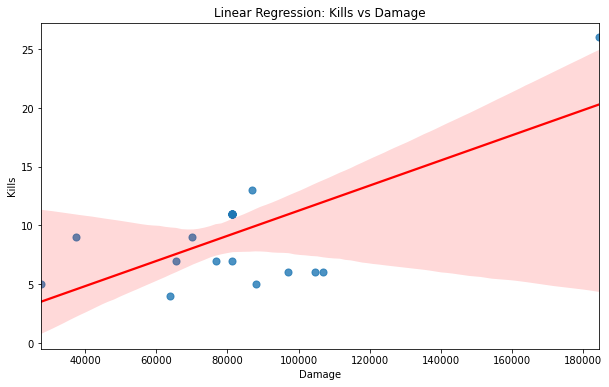

Linear Regression: Placement ~ Kills
                            OLS Regression Results                            
Dep. Variable:              Placement   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     10.33
Date:                Sat, 29 Jun 2024   Prob (F-statistic):            0.00456
Time:                        17:43:09   Log-Likelihood:                -35.005
No. Observations:                  21   AIC:                             74.01
Df Residuals:                      19   BIC:                             76.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

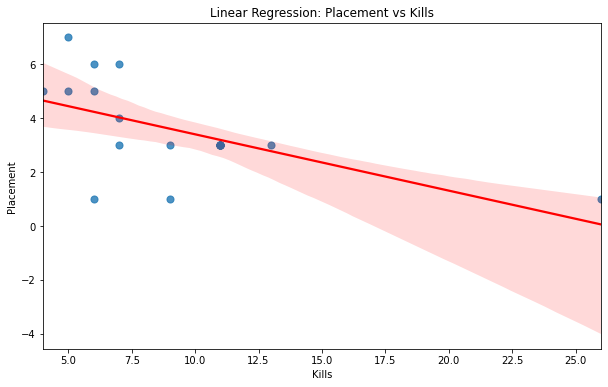

Linear Regression: Placement ~ Damage
                            OLS Regression Results                            
Dep. Variable:              Placement   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4.771
Date:                Sat, 29 Jun 2024   Prob (F-statistic):             0.0417
Time:                        17:43:09   Log-Likelihood:                -37.213
No. Observations:                  21   AIC:                             78.43
Df Residuals:                      19   BIC:                             80.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

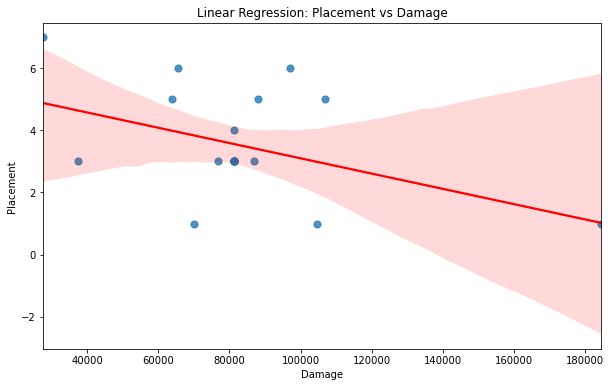

Linear Regression: Deaths ~ Damage
                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                   0.03347
Date:                Sat, 29 Jun 2024   Prob (F-statistic):              0.857
Time:                        17:43:09   Log-Likelihood:                -49.446
No. Observations:                  21   AIC:                             102.9
Df Residuals:                      19   BIC:                             105.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.

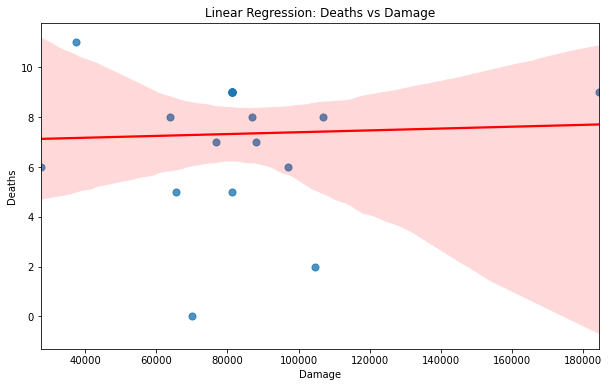

Linear Regression: Assists ~ Damage
                            OLS Regression Results                            
Dep. Variable:                Assists   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                   0.04918
Date:                Sat, 29 Jun 2024   Prob (F-statistic):              0.827
Time:                        17:43:09   Log-Likelihood:                -55.254
No. Observations:                  21   AIC:                             114.5
Df Residuals:                      19   BIC:                             116.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6

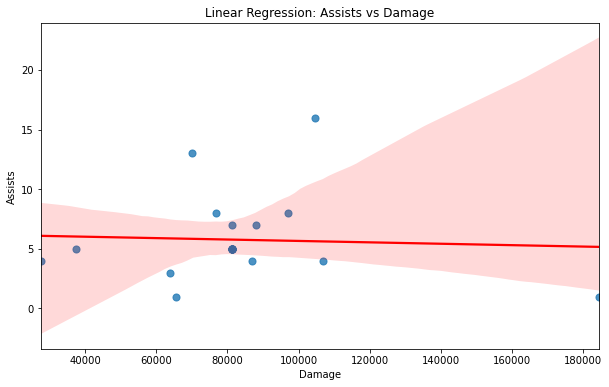

In [201]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV file
csv_filename = 'ArenaTracker.csv'
data = pd.read_csv(csv_filename)

# Handle missing and infinite values
data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
data.dropna(subset=['Kills', 'Placement', 'Damage', 'Deaths', 'Assists'], inplace=True)

# Define a function to perform linear regression
def perform_linear_regression(dependent_var, independent_var):
    # Prepare the data
    X = data[independent_var]
    y = data[dependent_var]

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(f"Linear Regression: {dependent_var} ~ {independent_var}")
    print(model.summary())
    
    # Plot the relationship
    plt.figure(figsize=(10, 6))
    sns.regplot(x=independent_var, y=dependent_var, data=data, scatter_kws={"s": 50}, line_kws={"color": "red"})
    plt.xlabel(independent_var)
    plt.ylabel(dependent_var)
    plt.title(f"Linear Regression: {dependent_var} vs {independent_var}")
    plt.show()

# Parameters to analyze
parameters = [
    ('Kills', 'Damage'),
    ('Placement', 'Kills'),
    ('Placement', 'Damage'),
    ('Deaths', 'Damage'),
    ('Assists', 'Damage')
]

# Perform linear regression for each pair of parameters
for dependent_var, independent_var in parameters:
    perform_linear_regression(dependent_var, independent_var)


## CSV Creater/Overwriter

In [71]:
overwriteperms = True

In [130]:

if overwriteperms == True:
    
    import csv

    # Define the headers
    headers = [
        'Champ', 'Game', "Prismatic Item", "Augment 1", 'Augment 2', 'Augment 3', 'Augment 4', 
        'Placement', 'Teammate', 'IsPremade', 'Kills', 'Deaths', "Assists",
        'Damage', 'Item 0', 'Item 1', 'Item 2', 'Item 3', 'Item 4', 
        'Item 5', 'Item 6'
    ]

    # Define the filename
    filename = 'ArenaTrackerr.csv'

    # Open the file for writing
    with open(filename, mode='w', newline='') as file:
        # Create a csv writer object
        writer = csv.writer(file)

        # Write the header
        writer.writerow(headers)

        # Optionally, write some data rows
        # writer.writerow(['example_champ', 'example_game', 'example_aug_1', ...])

    print(f"CSV file '{filename}' created successfully with the specified headers.")

else:
    print("Overwrite perms off")

Overwrite perms off


## CSV Last Line Deleter

In [216]:
if overwriteperms == True:
    import csv

    # Define the filename
    filename = 'ArenaTracker.csv'

    # Read the existing data from the CSV file
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        data = list(reader)  # Convert iterator to list of lists

    # Remove the last row from the data
    if len(data) > 0:
        data = data[:-1]  # Remove the last element (last row)

    # Write the updated data back to the CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

    print(f"Last row deleted successfully from '{filename}'.")
else:
    print("Overwrite perms off")

Last row deleted successfully from 'ArenaTracker.csv'.


# Step 1: Teammate selection

In [81]:
TeammateChamp = 'Riven'  # Manually inputted teammate champ name
PremadeYes = False  # Manually inputted premade status


# Step 2: Importer from riot api
## API Webpage = https://developer.riotgames.com/
You need a new api key every 24 hours

In [102]:
import requests
import json
import csv

#Your data
API_KEY = 'RGAPI-7bbd84e1-dc26-424c-9139-14974846c31a'
SUMMONER_NAME = 'femmesangfroid'
REGION = 'euw1'
GLOBAL_REGION = 'europe'
gameName = "femmesangfroid"
tagLine = "inter"

# List of prismatic items
prismatic_items = [
    "Eleisa's Miracle", "Gambler's Blade", "Night Harvester", "Cruelty", "Hemomancer's Helm",
    "Cloak of Starry Night", "Hamstringer", "Shield of Molten Stone", "Runecarver", "Flesheater",
    "Sanguine Gift", "Demonic Embrace", "Dragonheart", "Reality Fracture", "Duskblade of Draktharr",
    "Talisman of Ascension", "Turbo Chemtank", "Darksteel Talons", "Mirage Blade", "Sword of the Divine",
    "Empyrean Promise", "Divine Sunderer", "Decaitator", "Force of Entropy", "Detonation Orb",
    "Crown of the Shattered Queen", "Innervating Locket", "Prowler's Claw", "Radiant Virtue",
    "Moonflar Spellblade", "Demon King's Crown", "Overlord's Broodmail", "Gargoyle Stoneplate",
    "Everfrost", "Fulmination", "Galeforce"
]


# Load item data from JSON file
with open('item.json', 'r') as f:
    item_data = json.load(f)

# Load augments data from JSON file and create a dictionary for quick lookup
with open('augments.json', 'r') as f:
    augments_data = json.load(f)
    augments_dict = {augment['id']: augment['nameTRA'] for augment in augments_data}

# Function to get augment name based on ID using the dictionary
def get_augment_name(augment_id):
    augment_name = augments_dict.get(augment_id, '')
    return augment_name


# 1. Get Summoner ID
summoner_url = f'https://{GLOBAL_REGION}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}'
response = requests.get(summoner_url, headers={"X-Riot-Token": API_KEY})
summoner_data = response.json()
puuid = summoner_data['puuid']

# Step 2: Get Match History (Assuming last match)
match_history_url = f'https://{GLOBAL_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=1'
response = requests.get(match_history_url, headers={"X-Riot-Token": API_KEY})
match_ids = response.json()
last_match_id = match_ids[0]

# Step 3: Get Match Details
match_details_url = f'https://{GLOBAL_REGION}.api.riotgames.com/lol/match/v5/matches/{last_match_id}'
response = requests.get(match_details_url, headers={"X-Riot-Token": API_KEY})
match_details = response.json()

# Step 4: Extract your specific data from the match details
my_data = None
for participant in match_details['info']['participants']:
    if participant['puuid'] == puuid:
        my_data = participant
        break

# Step 5: Create a dictionary to map item IDs to item names
item_dict = {item_id: details['name'] for item_id, details in item_data['data'].items()}

# Step 6: Extract specific data and prepare for CSV
if my_data:
    extracted_data = {
        'Champ': my_data.get('championName', ''),
        'Game': '',  # Placeholder for the game number
        'Prism': '',  # Placeholder for Prism augment, adjust as needed
        'Aug 1': get_augment_name(my_data.get('playerAugment1', 0)),
        'Aug 2': get_augment_name(my_data.get('playerAugment2', 0)),
        'Aug 3': get_augment_name(my_data.get('playerAugment3', 0)),
        'Aug 4': get_augment_name(my_data.get('playerAugment4', 0)),
        'Placement': my_data.get('placement', 0),
        'Teammate': TeammateChamp,
        'IsPremade': 'Yes' if PremadeYes else 'No',
        'Kills': my_data.get('kills', 0),
        'Deaths': my_data.get('deaths', 0),
        'Assists': my_data.get('assists', 0),  # Add assists data here
        'Damage': my_data.get('totalDamageDealt', 0),   
        'Item 0': item_dict.get(str(my_data.get('item0', 0)), ''),
        'Item 1': item_dict.get(str(my_data.get('item1', 0)), ''),
        'Item 2': item_dict.get(str(my_data.get('item2', 0)), ''),
        'Item 3': item_dict.get(str(my_data.get('item3', 0)), ''),
        'Item 4': item_dict.get(str(my_data.get('item4', 0)), ''),
        'Item 5': item_dict.get(str(my_data.get('item5', 0)), ''),
        'Item 6': item_dict.get(str(my_data.get('item6', 0)), '')
    }
    
    # Check for prismatic items equipped
    for i in range(7):
        item_name = item_dict.get(str(my_data.get(f'item{i}', 0)), '')
        if item_name in prismatic_items:
            extracted_data['Prism'] = item_name
            break
    
    # Check for duplicates in the CSV file and set the game number
    last_game_number = 0
    duplicate_row = False
    try:
        with open('ArenaTracker.csv', 'r', newline='') as file:
            count = 0
            reader = csv.DictReader(file)
            for row in reader:
                # Check for duplicate excluding 'Champ' and 'Game' columns
                if row['Champ'] == extracted_data['Champ']:
                    count+=1
            last_game_number = count+1
    except FileNotFoundError:
        # If the file does not exist, start the game number at 1
        last_game_number = 1


    # Set the game number based on the condition
    extracted_data['Game'] = str(last_game_number if last_game_number > 0 else 1)


    # Append to CSV file
    with open('ArenaTracker.csv', 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=extracted_data.keys())
        writer.writerow(extracted_data)
        print("Data appended successfully.")
        print("Data Added is: ",extracted_data)
else:
    print("Your data was not found in the match details.")




Data appended successfully.
Data Added is:  {'Champ': 'Ahri', 'Game': '3', 'Prism': 'Detonation Orb', 'Aug 1': 'Eureka', 'Aug 2': 'Bread And Butter', 'Aug 3': 'Courage of the Colossus', 'Aug 4': 'Shadow Runner', 'Placement': 3, 'Teammate': 'Darius', 'IsPremade': 'No', 'Kills': 7, 'Deaths': 7, 'Assists': 8, 'Damage': 76913, 'Item 0': 'Malignance', 'Item 1': "Zhonya's Hourglass", 'Item 2': 'Detonation Orb', 'Item 3': "Liandry's Torment", 'Item 4': "Rabadon's Deathcap", 'Item 5': 'Cryptbloom', 'Item 6': 'Arcane Sweeper'}


In [103]:
import csv 

from csv import reader

### data set ###
opened_file = open('ArenaTracker.csv')
read_file = reader(opened_file)
arena = list(read_file)
arena_header = arena[0]
arena = arena[1:]


In [32]:
full = None
for item in arena_header[0:]:
    full = str(full)+"|"+str(item)
print(full)
print(len(arena_header))

None|Champ|Game|Prismatic Item|Augment 1|Augment 2|Augment 3|Augment 4|Placement|Teammate|IsPremade|Kills|Deaths|Assists|Damage|Item 0|Item 1|Item 2|Item 3|Item 4|Item 5|Item 6
21


|Champ|Game|Prismatic Item|Augment 1|Augment 2|Augment 3|Augment 4|Placement|Teammate|IsPremade|Kills|Deaths|Assists|Damage|Item 0|Item 1|Item 2|Item 3|Item 4|Item 5|Item 6
|    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----: |
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|


In [123]:
yestable = True
filename = "ArenaTracker.csv"

import csv

from IPython.display import display, Markdown

def read_csv(filename):
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        rows = list(reader)
    return rows

def format_as_markdown_table(rows):
    # Ensure there is at least one row
    if not rows:
        return ""

    # Extract headers and rows
    headers = rows[0]
    data = rows[1:]

    # Calculate column widths
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(cell))

    # Create the header row
    header_row = "| " + " | ".join(f"{header.ljust(col_widths[i])}" for i, header in enumerate(headers)) + " |"
    
    # Create the separator row
    separator_row = "| " + " | ".join('-' * col_width for col_width in col_widths) + " |"
    
    # Create the data rows
    data_rows = [
        "| " + " | ".join(f"{cell.ljust(col_widths[i])}" for i, cell in enumerate(row)) + " |"
        for row in data
    ]

    # Combine all rows into a single Markdown string
    markdown_table = "\n".join([header_row, separator_row] + data_rows)
    
    return markdown_table

def display_markdown_table(filename):
    rows = read_csv(filename)
    markdown_table = format_as_markdown_table(rows)
    display(Markdown(markdown_table))


if yestable == True:
    filename = 'ArenaTracker.csv'
    display_markdown_table(filename)
else:
    print("No table")
    

| Champ   | Game | Prismatic Item         | Augment 1              | Augment 2        | Augment 3               | Augment 4     | Placement | Teammate | IsPremade | Kills | Deaths | Assists | Damage | Item 0           | Item 1              | Item 2                 | Item 3            | Item 4             | Item 5             | Item 6         |
| ------- | ---- | ---------------------- | ---------------------- | ---------------- | ----------------------- | ------------- | --------- | -------- | --------- | ----- | ------ | ------- | ------ | ---------------- | ------------------- | ---------------------- | ----------------- | ------------------ | ------------------ | -------------- |
| Aatrox  | 1    | Prowler's Claw         | Thread the Needle      | Jeweled Gauntlet | Outlaw's Grit           | Vengeance     | 3         | Nami     | No        | 9     | 11     | 5       | 37403  | Black Cleaver    | Ravenous Hydra      | Prowler's Claw         | Spirit Visage     | Sterak's Gage      | Sundered Sky       | Arcane Sweeper |
| Aatrox  | 2    | Overlord's Broodmail   | Jeweled Gauntlet       | Goliath          | Mystic Punch            |               | 7         | Brand    | No        | 5     | 6      | 4       | 27596  | Black Cleaver    | Ravenous Hydra      | Overlord's Broodmail   | Spirit Visage     | Sterak's Gage      | Sundered Sky       | Arcane Sweeper |
| Aatrox  | 3    | Duskblade of Draktharr | Soul Siphon            | Giant Slayer     | Thread the Needle       |               | 6         | Gwen     | No        | 6     | 6      | 8       | 96913  | Guardian's Blade | Mercury's Treads    | Duskblade of Draktharr | Sundered Sky      | Sterak's Gage      | Atma's Reckoning   | Arcane Sweeper |
| Aatrox  | 4    | Prowler's Claw         | Goliath                | Blunt Force      | First-Aid Kit           | Dive Bomber   | 1         | Brand    | No        | 6     | 2      | 16      | 104528 | Black Cleaver    | Ravenous Hydra      | Prowler's Claw         | Spirit Visage     | Sterak's Gage      | Sundered Sky       | Arcane Sweeper |
| Ahri    | 1    | Reality Fracture       | Apex Inventor          | ADAPt            | Earthwake               |               | 5         | Samira   | No        | 5     | 7      | 7       | 88031  | Guardian's Orb   | Sorcerer's Shoes    | Reality Fracture       | Heartsteel        | Eclipse            | Unending Despair   | Arcane Sweeper |
| Akali   | 1    | Runecarver             | Witchful Thinking      | ADAPt            | Earthwake               |               | 5         | Garen    | No        | 6     | 8      | 4       | 106720 | Perplexity       | Hextech Gunblade    | Runecarver             | Sorcerer's Shoes  | Lich Bane          | Rabadon's Deathcap | Arcane Sweeper |
| Ahri    | 2    | Dragonheart            | Magic Missile          | Vengeance        | Big Brain               |               | 4         | Diana    | No        | 7     | 5      | 7       | 81408  | Shadowflame      | Sorcerer's Shoes    | Dragonheart            | Liandry's Torment | Blackfire Torch    | Perplexity         | Arcane Sweeper |
| Ahri    | 3    | Detonation Orb         | Eureka                 | Bread And Butter | Courage of the Colossus | Shadow Runner | 3         | Darius   | No        | 7     | 7      | 8       | 76913  | Malignance       | Zhonya's Hourglass  | Detonation Orb         | Liandry's Torment | Rabadon's Deathcap | Cryptbloom         | Arcane Sweeper |
| Alistar | 1    | Gargoyle Stoneplate    | Center of the Universe | Dashing          | Apex Inventor           | Impassable    | 1         | Riven    | No        | 9     | 0      | 13      | 70109  | Unending Despair | Gargoyle Stoneplate | Mercury's Treads       | Heartsteel        | Kaenic Rookern     | Sundered Sky       | Arcane Sweeper |

In [124]:
#to make a list of augments
def collater(column, lib):
    for item in column:
        if item not in lib:
            lib.append(item)
    return lib
    

In [125]:
def extract_column(matrix, col_index):
    column = []
    for row in matrix:
        if len(row) > col_index:
            column.append(row[col_index])
    return column

#I am writing a function to create lists by column. The columns go champset, gameset, firstaug, itemset, secondaug, thirdaug, fourthaug, placeset, teamset. Repeat the function for each column.
champset = extract_column(arena, 0)
gameset = extract_column(arena, 1)
prismset = extract_column(arena, 2)
firstaug = extract_column(arena, 3)
secondaug = extract_column(arena, 4)
thirdaug = extract_column(arena, 5)
fourthaug = extract_column(arena, 6)
placeset = extract_column(arena, 7)
teamset = extract_column(arena, 8)
killset = extract_column(arena, 10)
deathset = extract_column(arena, 11)
assistset = extract_column(arena, 12)
damageset = extract_column(arena, 13)
item1set = extract_column(arena, 14)
item2set = extract_column(arena, 15)
item3set = extract_column(arena, 16)
item4set = extract_column(arena, 17)
item5set = extract_column(arena, 18)
item6set = extract_column(arena, 19)

augset1 = []
augset1.append(firstaug)
augset1.append(secondaug)
augset1.append(thirdaug)
augset1.append(fourthaug)

augset = []
for row in augset1:
    for item in row:
        augset.append(item)
        
itemset1 = []
itemset1.append(item1set)
itemset1.append(item2set)
itemset1.append(item3set)
itemset1.append(item4set)
itemset1.append(item5set)
itemset1.append(item6set)

itemset = []
for row in itemset1:
    for item in row:
        itemset.append(item)
    

champs = []
games = []
augments = []
items = []
places = []
teammates = []
prismatics = []


print(augset1, "\n")
print(augset)


[['Thread the Needle', 'Jeweled Gauntlet', 'Soul Siphon', 'Goliath', 'Apex Inventor', 'Witchful Thinking', 'Magic Missile', 'Eureka', 'Center of the Universe'], ['Jeweled Gauntlet', 'Goliath', 'Giant Slayer', 'Blunt Force', 'ADAPt', 'ADAPt', 'Vengeance', 'Bread And Butter', 'Dashing'], ["Outlaw's Grit", 'Mystic Punch', 'Thread the Needle', 'First-Aid Kit', 'Earthwake', 'Earthwake', 'Big Brain', 'Courage of the Colossus', 'Apex Inventor'], ['Vengeance', '', '', 'Dive Bomber', '', '', '', 'Shadow Runner', 'Impassable']] 

['Thread the Needle', 'Jeweled Gauntlet', 'Soul Siphon', 'Goliath', 'Apex Inventor', 'Witchful Thinking', 'Magic Missile', 'Eureka', 'Center of the Universe', 'Jeweled Gauntlet', 'Goliath', 'Giant Slayer', 'Blunt Force', 'ADAPt', 'ADAPt', 'Vengeance', 'Bread And Butter', 'Dashing', "Outlaw's Grit", 'Mystic Punch', 'Thread the Needle', 'First-Aid Kit', 'Earthwake', 'Earthwake', 'Big Brain', 'Courage of the Colossus', 'Apex Inventor', 'Vengeance', '', '', 'Dive Bomber', '

In [126]:
champs = collater(champset,champs)
games = collater(gameset, games)
augments = collater (augset,augments)
items = collater(itemset,items)
places = collater(placeset,places)
teammates = collater(teamset, teammates)
prismatics = collater(prismset, prismatics)



# Libraries

In [107]:
print("Champs played: ",champs)
print("Augments picked", augments)
print("Items Bought",items)
print("Teammates Inted", teammates)

Champs played:  ['Aatrox', 'Ahri', 'Akali']
Augments picked ['Thread the Needle', 'Jeweled Gauntlet', 'Soul Siphon', 'Goliath', 'Apex Inventor', 'Witchful Thinking', 'Magic Missile', 'Eureka', 'Giant Slayer', 'Blunt Force', 'ADAPt', 'Vengeance', 'Bread And Butter', "Outlaw's Grit", 'Mystic Punch', 'First-Aid Kit', 'Earthwake', 'Big Brain', 'Courage of the Colossus', '', 'Dive Bomber', 'Shadow Runner']
Items Bought ['Black Cleaver', "Guardian's Blade", "Guardian's Orb", 'Perplexity', 'Shadowflame', 'Malignance', 'Ravenous Hydra', "Mercury's Treads", "Sorcerer's Shoes", 'Hextech Gunblade', "Zhonya's Hourglass", "Prowler's Claw", "Overlord's Broodmail", 'Duskblade of Draktharr', 'Reality Fracture', 'Runecarver', 'Dragonheart', 'Detonation Orb', 'Spirit Visage', 'Sundered Sky', 'Heartsteel', "Liandry's Torment", "Sterak's Gage", 'Eclipse', 'Lich Bane', 'Blackfire Torch', "Rabadon's Deathcap", "Atma's Reckoning", 'Unending Despair', 'Cryptbloom']
Teammates Inted ['Nami', 'Brand', 'Gwen', 'S

# Champions Finished

In [108]:
wins_left = 60
for row in arena:
    placement_game = row[7]
    champ_name = row[0]
    game_number = row[1]
    if placement_game == "1":
        print(champ_name,"is finished. It took",game_number,"games. \n")
        wins_left = wins_left-1
if wins_left == 60:
        print("No champs are finished.")
print("Wins left before title:",wins_left)
print("Total games played:", len(arena))

Aatrox is finished. It took 4 games. 

Wins left before title: 59
Total games played: 8


In [127]:
def highestcounter(lib, column):
    highestcount_count = 0
    highestcount_name = None

    for unique_item in set(lib):  # Use set to iterate over unique items in lib
        count = 0
        for cell in column:
            if unique_item == cell and unique_item != "":
                count += 1
        if count > highestcount_count:
            highestcount_count = count
            highestcount_name = unique_item
    return highestcount_name



In [128]:
def calculate_average(numbers):
    # Convert the list of strings to a list of integers
    numeric_values = [int(num) for num in numbers]
    
    if not numeric_values:
        return 0  # Handle the case for an empty list
    
    total_sum = sum(numeric_values)
    count = len(numeric_values)
    average = total_sum / count
    return average

mc_champ = highestcounter(champs,champset)
mc_augment = highestcounter(augments,augset)
mc_prismatic = highestcounter(prismatics,prismset)
avg_placement = calculate_average(placeset)
mc_teammate = highestcounter(teammates,teamset)
avg_kills = calculate_average(killset)
avg_deaths = calculate_average(deathset)
avg_assists = calculate_average(assistset)
avg_kdaa = (avg_kills+avg_assists)/avg_deaths
avg_kda = f"{avg_kdaa:.3}"
avg_damage = calculate_average(damageset)






Akali 1
Aatrox 4
Alistar 1
Ahri 3
 0
Dive Bomber 1
Big Brain 1
Bread And Butter 1
ADAPt 2
Goliath 2
Giant Slayer 1
Courage of the Colossus 1
Blunt Force 1
Jeweled Gauntlet 2
Thread the Needle 2
Mystic Punch 1
Vengeance 2
Center of the Universe 1
Apex Inventor 2
Eureka 1
Witchful Thinking 1
Magic Missile 1
Shadow Runner 1
First-Aid Kit 1
Outlaw's Grit 1
Soul Siphon 1
Dashing 1
Impassable 1
Earthwake 2
Reality Fracture 1
Detonation Orb 1
Prowler's Claw 2
Runecarver 1
Dragonheart 1
Overlord's Broodmail 1
Gargoyle Stoneplate 1
Duskblade of Draktharr 1
Garen 1
Riven 1
Brand 2
Gwen 1
Nami 1
Darius 1
Samira 1
Diana 1


In [129]:
from IPython.display import display, Markdown

# Create the table as a Markdown string

table = f"""
| Champ | Augment | Prismatic | Placement | Teammate | KDA | Damage | 
|--------|--------|--------|--------|--------|--------|--------|
| {mc_champ} |  {mc_augment} | {mc_prismatic} | {avg_placement} | {mc_teammate} | {avg_kda} | {avg_damage} |
"""
# Display the table
display(Markdown(table))


| Champ | Augment | Prismatic | Placement | Teammate | KDA | Damage | 
|--------|--------|--------|--------|--------|--------|--------|
| Aatrox |  ADAPt | Prowler's Claw | 3.888888888888889 | Brand | 2.54 | 76624.55555555556 |
